#Seismic forward modeling using Python programming language: algorithm for flexible solution.

## Intorduction

![Artemii](https://scontent.fosl1-1.fna.fbcdn.net/v/t31.0-8/19679093_1878249049167090_2608727483842097107_o.jpg?_nc_cat=108&oh=323a93dbfe821eebd3093becbd97f1bd&oe=5C148FA5 =500x) ![Lukoil](https://www.azernews.az/media/pictures/lukoil_logo_.jpg =500x)



**Artemii Novoselov**, MSc

*Geoscientist* at Lukoil Overseas North Shelf AS

## Structure

![Intro](https://image.ibb.co/kOkTzU/Intro.png)

## Import and Installation Section

### Import External Libraries

In [0]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import numpy as np
import scipy as sp
import scipy.ndimage as snd
import copy
import os
import pandas as pd
from scipy.interpolate import interp1d

### Google Drive Authorization

In [2]:
!pip install PyDrive

    100% |████████████████████████████████| 993kB 5.9MB/s 
  Running setup.py bdist_wheel for PyDrive ... - \ done
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Download Horizons

In [2]:
!wget https://github.com/crimeacs/Seismic_Forward_Modeling/raw/master/Export.zip


Redirecting output to ‘wget-log’.


## Define Functions

In [0]:
def resizing_array(x, out_max):
    if int(out_max/len(x)) > 1:
        x = x[::int(out_max/len(x))]
    else: x = x[::1]
    while len(x) > out_max:
        x = np.delete(x, -1)
    return x
  
def map_and_resize(x, x_min, x_max, out_min, out_max):
    mapped = ((x - x_min) * (out_max - out_min) // (x_max - x_min) + out_min).astype(int)
    z = mapped
    return z

## Input Data

![alt text](http://www.opendtect.org/osr/uploads/Main/F3_Block.png =600x)

Data Set from Holland F3 Block in North Sea

## Read Horizons

![dGB](https://img.aapg.org/Portals/0/images/_logo/250x170/dgb-250x170.jpg =80x) ![Open Data](http://www.datamashup.info/wp-content/uploads/Opendata.png  =80x)
Download Horizons from [OpendTect Data Portal](http://www.opendtect.org/osr/Main/NetherlandsOffshoreF3BlockSeismicOnly494MB)


In [0]:
import zipfile
with zipfile.ZipFile("Export.zip","r") as zip_ref:
    zip_ref.extractall("targetdir")

In [5]:
cd targetdir/

/content/targetdir


Read Horizons

In [0]:
filenames = [f for f in os.listdir('.') if os.path.isfile(f)]
data = pd.DataFrame(columns = ['x', 'y', 'z', 'Filename'])
n = 0
for filename in filenames:

  df = pd.read_table(filename, header=None, encoding='utf-8', sep=" ", names=['In-line', 'X-line', 'z'])
  df['Filename'] = filenames[n]
  df['In-line'] = pd.to_numeric(df['In-line']).astype(int)
  df['X-line'] = pd.to_numeric(df['X-line']).astype(int)
  df['z'] = df['z']
  df['z'] = pd.to_numeric(df['z']).astype(int)
  
  data = data.append(df)
  n+=1

Nicely Display Them

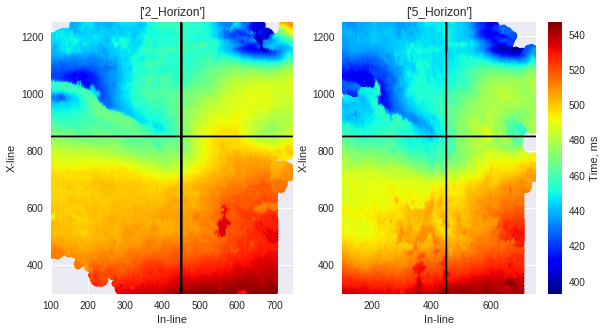

In [24]:
#@title Choose your inline { output-height: 200, form-width: "200px", display-mode: "form" }
xline = 850 #@param {type:"integer"}
inline = 450 #@param {type:"integer"}

grouped = data.groupby('Filename', sort=True)

figure = plt.figure(figsize=(20,5))


n = 0
k = 0
for group in grouped:
  n += 1
  if n % 3 == 0:
    k += 1
    plt.subplot(1,4,k)
    plt.scatter(group[1]['In-line'][::10], group[1]['X-line'][::10], c = group[1]['z'][::10], s = 50, cmap = 'jet')
    plt.xlabel('In-line')
    plt.ylabel('X-line')
    plt.title(group[1]['Filename'].unique())
    plt.ylim(300, 1250)
    plt.xlim(100, 750)
    plt.plot(group[1]['In-line'][::10], np.zeros(shape=(group[1]['X-line'][::10].shape)) + xline, color = 'black')
    plt.plot(np.zeros(shape=(group[1]['X-line'][::10].shape)) + inline, group[1]['X-line'][::10], color = 'black')
cbar = plt.colorbar()
cbar.set_label('Time, ms')

See them in Slice-View

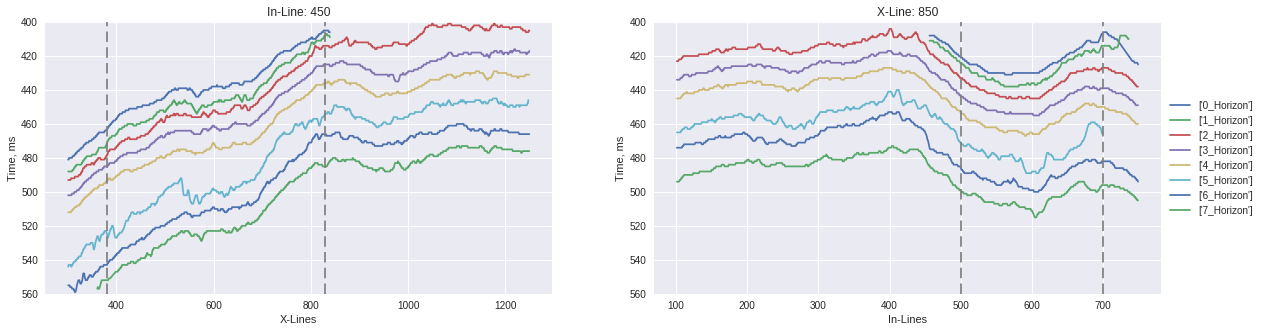

In [30]:
#@title Zoom closer { output-height: 200, form-width: "300px", display-mode: "form" }
cut_x_line_left = 380 #@param {type:"slider", min:100, max:1200, step:1}
cut_x_line_right = 830 #@param {type:"slider", min:100, max:1200, step:1}
cut_in_line_left = 500 #@param {type:"slider", min:100, max:800, step:1}
cut_in_line_right = 700 #@param {type:"slider", min:100, max:800, step:1}

#Select all points for inline and xline separatly
in_slice = data.where(data['In-line'] == inline)
x_slice = data.where(data['X-line'] == xline)

#Group data by horizons
grouped_in = in_slice.groupby('Filename', sort=True)
grouped_x  = x_slice.groupby('Filename', sort=True)

#Create figure
fig = plt.figure(figsize=(20,5))

colors = ['#FFFF00', '#FDC07A', '#FDB46C', '#FDB46C', '#A6D84A', '#FFFF00', '#FDC07A', '#FDB46C', '#FDB46C', '#A6D84A', '#FFFF00', '#FDC07A', '#FDB46C', '#FDB46C', '#A6D84A']
#Plot In-line view
n = 0
plt.subplot(121)
for group in grouped_in:
  plt.plot(group[1]['X-line'], group[1]['z'], label=group[1]['Filename'].unique())
  n+=1
plt.ylim(560,400)
# plt.legend(loc='center left', bbox_to_anchor=(-0.1, 0.5))
plt.xlabel('X-Lines')
plt.ylabel('Time, ms')
plt.title('In-Line: %i' % inline)
plt.axvline(x = cut_x_line_left, c ='grey', dashes=[6, 3])
plt.axvline(x = cut_x_line_right, c ='grey', dashes=[6, 3])

#Plot X-line view
n = 0
plt.subplot(122)
for group in grouped_x:
  plt.plot(group[1]['In-line'], group[1]['z'], label=group[1]['Filename'].unique())
  n+=1
plt.ylim(560,400)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('In-Lines')
plt.ylabel('Time, ms')
plt.title('X-Line: %i' % xline)
plt.axvline(x = cut_in_line_left, c ='grey', dashes=[6, 3])
plt.axvline(x = cut_in_line_right, c ='grey', dashes=[6, 3])

In [0]:
#Zoom in
in_slice_crop = in_slice.where(in_slice['X-line'] <= cut_x_line_right)
in_slice_crop = in_slice_crop.where(in_slice_crop['X-line'] >= cut_x_line_left)

x_slice_crop = x_slice.where(x_slice['In-line'] <= cut_in_line_right)
x_slice_crop = x_slice_crop.where(x_slice_crop['In-line'] >= cut_in_line_left)

#Group data by horizons
grouped_in_crop = in_slice_crop.groupby('Filename', sort = True)
grouped_x_crop  = x_slice_crop.groupby('Filename', sort = True)

## Make Model

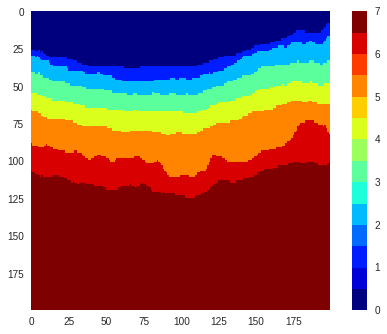

In [33]:
#Choose view

view = 'X-line'

#Create empty grid
if view == 'In-line':
  n_cells = cut_x_line_right-cut_x_line_left
  grouped = grouped_in_crop
elif view == 'X-line':
  n_cells = cut_in_line_right-cut_in_line_left
  grouped = grouped_x_crop

model = np.zeros(shape = (n_cells, n_cells), dtype=np.int)

n = 0

for group in grouped:
    # Rescale for the model dimensions
    layer = map_and_resize(group[1]['z'].values, 400, 560, 0, n_cells)
    x = np.arange(0, len(layer), 1)
    
    # Interpolate to fill gaps
    f = interp1d(x, layer)
    f2 = interp1d(x, layer, kind='cubic')
    x_new = np.arange(0,n_cells,1).astype('int')
    layer_new = f2(x_new).astype('int')
    #For the first layer
    if n == 0:
      layer_n = np.zeros_like(x_new)
      
    #For the last layer
    if n == len(filenames)-1:
      layer_new = np.zeros_like(x_new) + n_cells
    
    #Fill trace by trace
    for i in range(len(x_new)):
      model[layer_n[i]:layer_new[i],x_new[i]] = n

    layer_n = layer_new
    n += 1
    
# #Create new colormap
# cmap_name = 'Volve'
# cm = LinearSegmentedColormap.from_list(cmap_name, ['#FFFF99']+colors)
# plt.register_cmap(cmap=cm)

#Convert to discrete colormap
cmap = plt.get_cmap('jet', 14)
cmap.set_under('gray')

#Display the result
cax = plt.imshow(model, cmap=cmap)
plt.grid(False)
cbar = plt.colorbar(cax, ticks = np.arange(0,13,1))

# cbar.ax.set_yticklabels(['Undefined']+sorted(horizons))

According to description of the dataset:

The upper 1200ms of the demo set consists of reflectors belonging to the Miocene, Pliocene, and Pleistocene (Sørensen et al, 1997; Overeem et al, 2001)

Lets than asssume that:

0.   Layer is a clean **sandstone**
1.   Layer  consists of the **calcareous claystones, siltstones and marlstones**
2.   Layer consists of  **sandstone**
3.   Layer is **shales**
4.   Layer is a clean **shale**
5.   Layer  consists of the **calcareous claystones, siltstones and marlstones**
6.   Layer consists of  **calcareous claystones, siltstones and marlstones**
7.   Layer is **shales**

Therefore we can make an inital guess:

0.  Let **0** to be shale with properties $\rho$ = 2650 kg/m3, $V_p$ = 2300 m/s 
1.  **1** to be $\rho$ =  2750 kg/m3, $V_p$ = 2530 m/s
2.  **2** to be  $\rho$ = 2675 kg/m3, $V_p$ = 2500 m/s 
3.  **3** to be $\rho$ = 2680 kg/m3, $V_p$ = 2590 m/s 
4.  **4** to be $\rho$ = 2600 kg/m3, $V_p$ = 2340 m/s
5.  **5** to be $\rho$ = 2450 kg/m3, $V_p$ = 2530 m/s 
6.  **6** to be $\rho$ = 2420 kg/m3, $V_p$ = 2680 m/s
7.  **7** to be $\rho$ = 2375 kg/m3, $V_p$ = 2500 m/s 



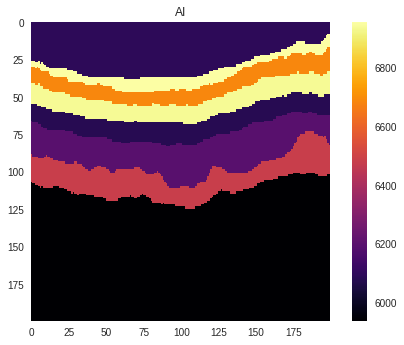

In [166]:
#Create model filled with density
model_dens = np.copy(model)
model_dens[model_dens == 0] = 2650
model_dens[model_dens == 1] = 2750
model_dens[model_dens == 2] = 2675
model_dens[model_dens == 3] = 2680
model_dens[model_dens == 4] = 2600
model_dens[model_dens == 5] = 2450
model_dens[model_dens == 6] = 2420
model_dens[model_dens == 7] = 2375

#Create model filled with Velocity
model_Vp  = np.copy(model)
model_Vp[model_Vp == 0] = 2300
model_Vp[model_Vp == 1] = 2530
model_Vp[model_Vp == 2] = 2500
model_Vp[model_Vp == 3] = 2590
model_Vp[model_Vp == 4] = 2340
model_Vp[model_Vp == 5] = 2530
model_Vp[model_Vp == 6] = 2680
model_Vp[model_Vp == 7] = 2500

model_AI = model_dens*model_Vp/1e3

plt.imshow(model_AI, cmap = 'inferno')
plt.title('AI')
plt.colorbar()
plt.grid(False)

## Make Faulted Model

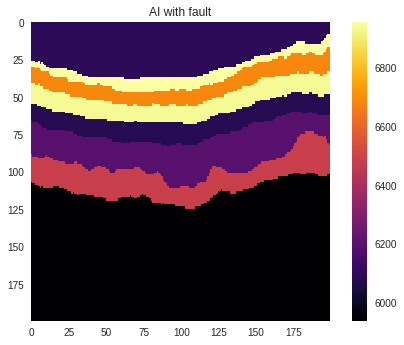

In [167]:
#@title Add Fault { output-height: 200, form-width: "300px", display-mode: "form" }
faulted = copy.deepcopy(model_AI)

fault_throw = 00 #@param {type:"integer"}

fault_position = 100 #@param {type:"integer"}

# fault  = np.arange(fault_position)

with_fault = np.roll(faulted[:,0:fault_position], fault_throw, axis=0)
with_fault = np.hstack([with_fault, faulted[:, fault_position:]])

faulted = with_fault

plt.imshow(faulted, cmap = 'inferno')
plt.title('AI with fault')
plt.colorbar()
plt.grid(False)

## Generate RC

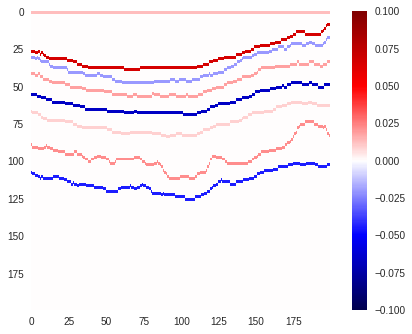

In [169]:
#Calculate Reflection Coefficient
width = 2

rc = (faulted - np.roll(faulted, width, axis=0))/(faulted + np.roll(faulted, width, axis=0))

plt.imshow(rc, cmap='seismic', vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.grid(False)

## Make Wavelets

Ricker's wavelet can be defined as:

$A = (1-2 \pi^2 f^2 t^2) e^{-\pi^2 f^2 t^2}$

where: 
*   $A$ - is Amplitude, 
*   $f$  - is frequency,
*   $t$  - is time.

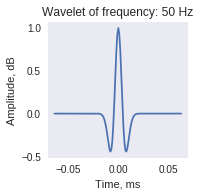

In [176]:
def ricker(f, length=0.128, dt=0.001):
    t = np.arange(-length/2, (length-dt)/2, dt)
    y = (1.0 - 2.0*(np.pi**2)*(f**2)*(t**2)) * np.exp(-(np.pi**2)*(f**2)*(t**2))
    return t, y
  

plt.figure(figsize=(2.5,2.5))
#@title Choose Frequency { output-height: 200, form-width: "300px", display-mode: "form" }
f = 50 #@param {type:"integer"}
t, w = ricker(f)
plt.plot(t,w)
plt.xlabel('Time, ms')
plt.ylabel('Amplitude, dB')
plt.title('Wavelet of frequency: %i Hz' % f)
plt.grid(False)

## Make Syntetics

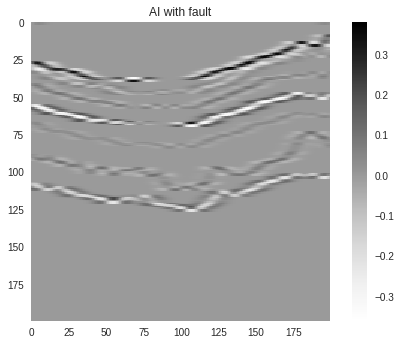

In [178]:
synth = np.array([np.apply_along_axis(lambda t: np.convolve(t, w, mode='same'), axis=0,
                             arr=r) for r in rc ])
plt.imshow(synth, cmap = 'Greys',)
plt.title('AI with fault')
plt.colorbar()
plt.grid(False)

## Add some noise and blur

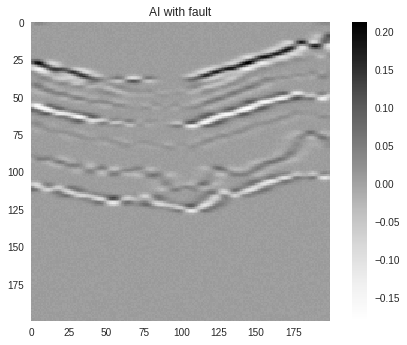

In [179]:
blurred = sp.ndimage.gaussian_filter(synth, sigma=1.1)
noisy = blurred + 0.5 * blurred.std() * np.random.random(blurred.shape)

plt.imshow(noisy, cmap = 'Greys',)
# plt.imshow(rc, cmap='seismic', vmin=-0.1, vmax=0.1, alpha=0.2)
plt.title('AI with fault')
plt.colorbar()
plt.grid(False)

### Original Seismic Image
![seism](https://i.postimg.cc/j2QWY3ds/Capture.jpg =400x)

## Summary and Conclusions

*   Scripting languages are very useful in scientific computations
*   Seismic forward modeling can be performed in a reasonable time
*   Forward modelling allows scientist to iterate through numerous variations of lithological and petrophysical parameters
*   Uncertainty level can be reduced 
*   Geologist’s expectations of geological setting can be proved or dismissed  


![GitHub](https://assets-cdn.github.com/images/modules/open_graph/github-octocat.png =200x) ![QR](https://chart.googleapis.com/chart?cht=qr&chl=https%3A%2F%2Fgithub.com%2Fcrimeacs%2FSeismic_Forward_Modeling&chs=180x180&choe=UTF-8&chld=L|2 =100x)

This code is avalable on my personal [GitHub page](https://github.com/crimeacs/Seismic_Forward_Modeling)